In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import matplotlib.image as mpimg
from matplotlib import cm
import matplotlib.animation as ani
from scipy.integrate import odeint
import pandas as pd
import copy

from sklearn.ensemble import RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
def plot_map(lat, long, para):
    amin = np.amin(para)
    amax = np.amax(para)
    matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
    fig = plt.figure()
    plt.pcolor(long, lat, para, cmap='seismic', vmin=max(abs(amin), abs(amax)), vmax=(-1)*max(abs(amin), abs(amax)))
    plt.tight_layout()
    cbar = plt.colorbar()

In [3]:
isotopes = Dataset('climatology/xnapa_isotopes.nc', "a")
precipitation = Dataset('climatology/xnapa_precip.nc', "a")
surface_temperature = Dataset('climatology/xnapa_temp.nc', "a")

In [4]:
lat = isotopes.variables["latitude"][:].data[1:-1]
long = isotopes.variables["longitude"][:].data
t = isotopes.variables["t"][:].data

trash = [626, 0]

In [31]:
def calculate_error(df_predictions, do18):  
    df_error = pd.DataFrame(columns=["mae", "mse"])
    for sample in range(len(df_predictions)):
        df_error.loc[sample, "mae"] = mean_absolute_error(do18.loc[sample].values, df_predictions.loc[sample].values)
    
    #print("Mean absolute error of test data:" ,df_error["mae"].mean())
    
    return df_error["mae"].mean()

In [6]:
do18 = []
precip = []
temp = []
for i in range(len(t)):
    do18.append(isotopes.variables["dO18"][i][0].data[1:-1].reshape(71*96))
    precip.append(precipitation.variables["precip"][i][0].data[1:-1].reshape(71*96))
    temp.append(surface_temperature.variables["temp_1"][i][0].data[1:-1].reshape(71*96))
    
do18 = pd.DataFrame(np.delete(np.delete(np.asarray(do18), 0, 0), 626, 0)[:1000])
precip = pd.DataFrame(np.delete(np.delete(np.asarray(precip), 0, 0), 626, 0)[:1000])
temp = pd.DataFrame(np.delete(np.delete(np.asarray(temp), 0, 0), 626, 0)[:1000])

In [33]:
def rfr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20, train_proportion=0.9, random=True):
    
    if random:
        random_idx = np.random.permutation(do18.index.values)
    
        temp = temp.reindex(random_idx)
        precip = precip.reindex(random_idx)
        do18 = do18.reindex(random_idx)
    
    #devide training and test data
    do18_train = do18[:int(np.floor(train_proportion*len(do18)))].reset_index(drop=True)
    do18_test = do18[int(np.floor(train_proportion*len(do18))):].reset_index(drop=True)

    temp_train = temp[:int(np.floor(train_proportion*len(temp)))].reset_index(drop=True)
    temp_test = temp[int(np.floor(train_proportion*len(temp))):].reset_index(drop=True)

    precip_train = precip[:int(np.floor(train_proportion*len(precip)))].reset_index(drop=True)
    precip_test = precip[int(np.floor(train_proportion*len(precip))):].reset_index(drop=True)
    
    #define scalers
    scaler_temp = StandardScaler().fit(temp)
    scaler_precip = StandardScaler().fit(precip)
    scaler_do18 = StandardScaler().fit(do18)
    
    #scale data
    do18_train_scaler = scaler_do18.transform(do18_train)
    do18_test_scaler = scaler_do18.transform(do18_test)

    temp_train_scaler = scaler_temp.transform(temp_train)
    temp_test_scaler = scaler_temp.transform(temp_test)

    precip_train_scaler = scaler_precip.transform(precip_train)
    precip_test_scaler = scaler_precip.transform(precip_test)
    
    #define pcas and fit data
    pca_temp = PCA(n_components=n_temp).fit(np.append(temp_train_scaler, temp_test_scaler, axis=0))
    pca_precip = PCA(n_components=n_precip).fit(np.append(precip_train_scaler, precip_test_scaler, axis=0))
    pca_do18 = PCA(n_components=n_y).fit(np.append(do18_train_scaler, do18_test_scaler, axis=0))
    
    #transform data
    do18_train_pc = pca_do18.transform(do18_train_scaler)
    do18_test_pc = pca_do18.transform(do18_test_scaler)

    temp_train_pc = pca_temp.transform(temp_train_scaler)
    temp_test_pc = pca_temp.transform(temp_test_scaler)

    precip_train_pc = pca_precip.transform(precip_train_scaler)
    precip_test_pc = pca_precip.transform(precip_test_scaler)
    
    
    X_train = np.append(temp_train_pc, precip_train_pc, axis=1)
    X_test = np.append(temp_test_pc, precip_test_pc, axis=1)

    Y_train = do18_train_pc
    Y_test = pd.DataFrame(do18_test_pc)
    
    Y = pd.DataFrame(np.append(Y_train, Y_test, axis=0))
    
    #train model
    regressor = RandomForestRegressor().fit(X_train, Y_train)
    
    #predict test data
    pred_pc = pd.DataFrame(regressor.predict(X_test))
    pred_norm = pd.DataFrame(pca_do18.inverse_transform(pred_pc))
    pred = pd.DataFrame(scaler_do18.inverse_transform(pred_norm))
    
    #inverse transform
    #do18_test_inverse = pd.DataFrame(scaler_do18.inverse_transform(pca_do18.inverse_transform(Y_test)))
    
    #importances = list(regressor.feature_importances_)
    #feature_list = []
    #for i in range(n_temp):
    #    feature_list.append("temp {}".format(i))
    #for i in range(n_precip):
    #    feature_list.append("precip {}".format(i))
    
    
    #return pca and final data
    return pred_pc, pred_norm, pred, Y_test, pd.DataFrame(do18_test_scaler), do18_test

## Sign Correlation

In [8]:
def calculate_sign_correlation(pred_norm, do18_test_scaler):
    sign_correlation = np.heaviside(pred_norm*do18_test_scaler, 0) 
    return sign_correlation

In [9]:
pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = rfr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)

In [12]:
calculate_error(pred, do18_test)

0.6981258726103559

In [176]:
sign_correlation_total = calculate_sign_correlation(pred_norm, do18_test_scaler)

In [177]:
for i in range(100):
    pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = rfr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)
    corr = calculate_sign_correlation(pred_norm, do18_test_scaler)
    sign_correlation_total = sign_correlation_total.append(corr)
sign_correlation_total = sign_correlation_total.reset_index(drop=True)

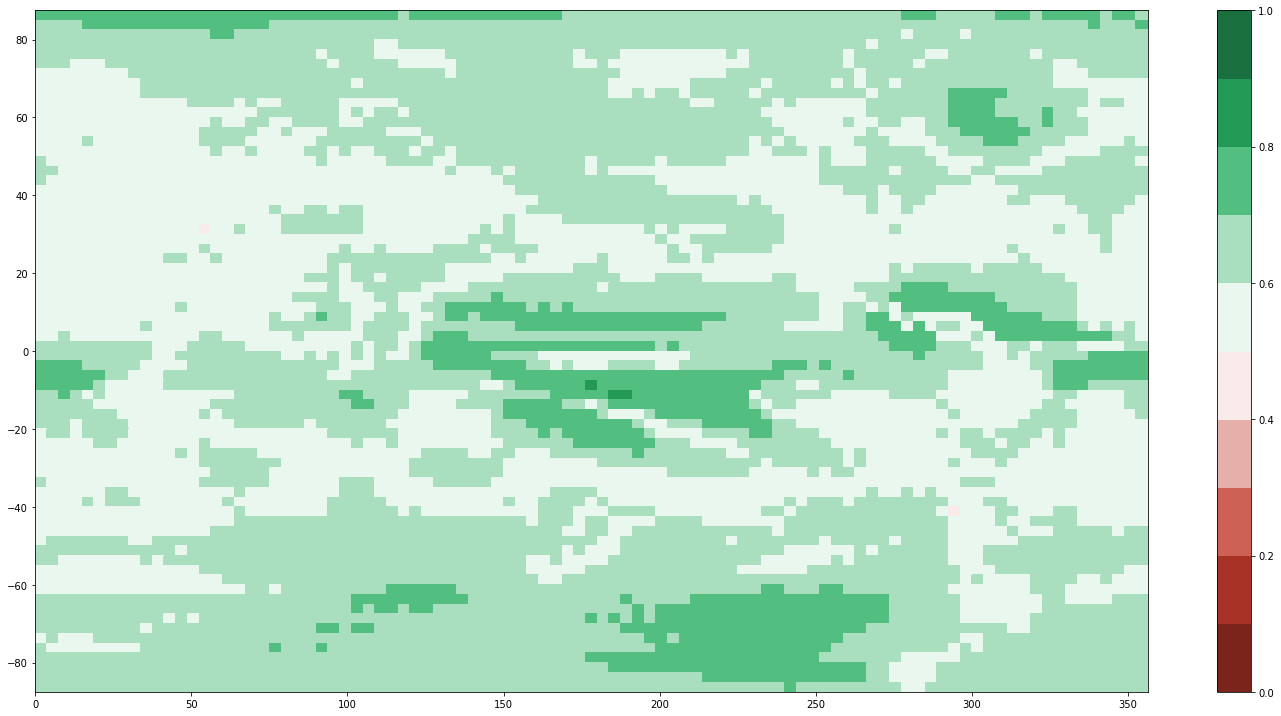

In [185]:
para = sign_correlation_total.mean().values.reshape(71,96)
amin = np.amin(para)
amax = np.amax(para)
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#7b241c", "#a93226", "#cd6155", "#e6b0aa", "#f9ebea", "#e9f7ef", "#a9dfbf", "#52be80", "#229954", "#145a32"]
cmap= matplotlib.colors.ListedColormap(colors)
norm= matplotlib.colors.Normalize(vmin=0,vmax=1)

plt.pcolor(long, lat, para,  cmap=cmap, vmin=0, vmax=1, norm=norm)
plt.tight_layout()
cbar = plt.colorbar()

In [186]:
pd.DataFrame(para).mean().values.mean()

0.6217930873192953

In [188]:
file = open("sign_correlation_rfr_pca.txt", "w")
dump = "\n".join(para.reshape(71*96).astype(str).tolist())
file.write(dump)

127892

## Mean deviation from mean values

In [8]:
pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = rfr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)

In [9]:
pred_list = copy.deepcopy(pred)
test_list = copy.deepcopy(do18_test)

In [10]:
for i in range(100):
    pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = rfr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)
    pred_list = pred_list.append(pred)
    test_list = test_list.append(do18_test)
pred_list = pred_list.reset_index(drop=True)
test_list = test_list.reset_index(drop=True)

In [11]:
rmse_geolist = []
for pixel in test_list.columns.values:
    rmse_pixel = mean_squared_error(pred_list[pixel].values, test_list[pixel].values, squared=False)
    rmse_geolist.append(rmse_pixel)
df_rmse_geolist = pd.DataFrame(np.asarray(rmse_geolist).reshape(71,96))

In [21]:
df_rmse_geolist.mean().mean()

0.8922147278921013

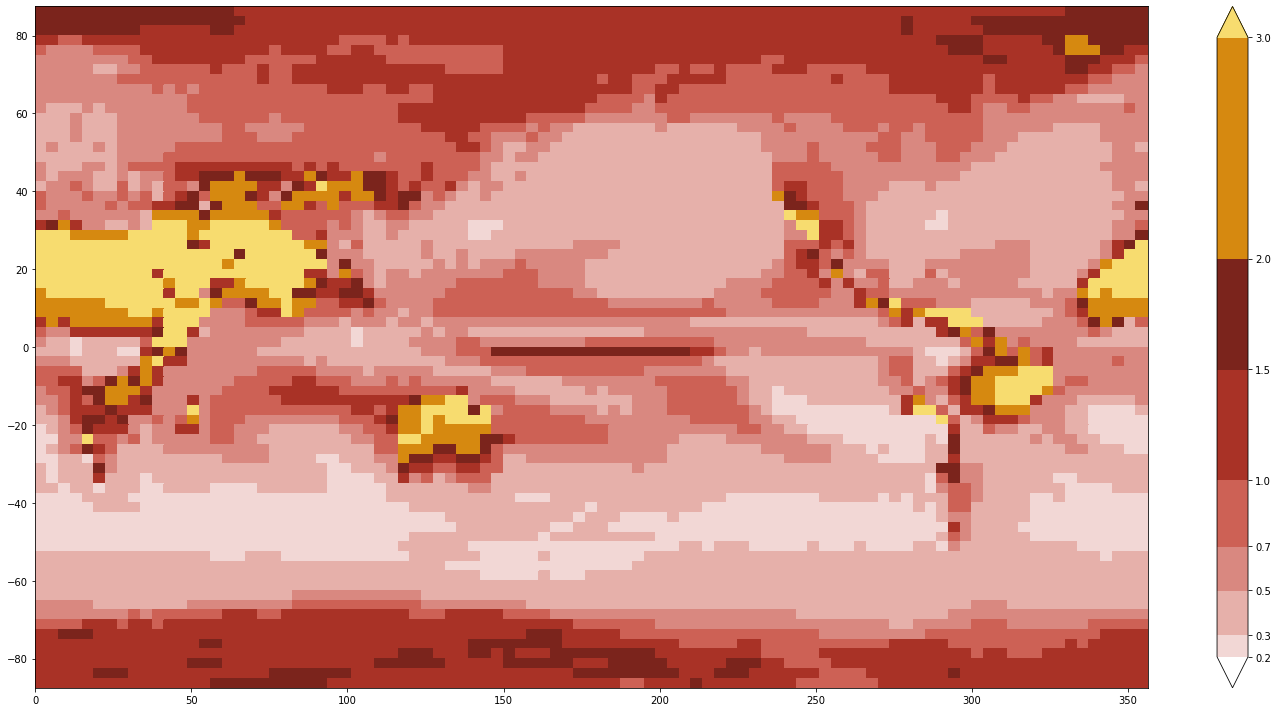

In [15]:
para = df_rmse_geolist.values

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#f2d7d5", "#e6b0aa", "#d98880", "#cd6155", "#a93226", "#7b241c", "#d68910"]
bounds = [0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]
cmap= matplotlib.colors.ListedColormap(colors)
cmap.set_under("#ffffff")
cmap.set_over("#f7dc6f")
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(
    long, lat, 
    para, 
    cmap=cmap, 
    vmin=0.1, vmax=3, norm=norm
)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    extend="both", 
    ticks=bounds, 
    spacing='proportional'
)

In [41]:
file = open("rmse_rfr_pca.txt", "w")
dump = "\n".join(para.reshape(71*96).astype(str).tolist())
file.write(dump)

129598

In [8]:
std = pd.DataFrame(do18.std().values.reshape(71,96))

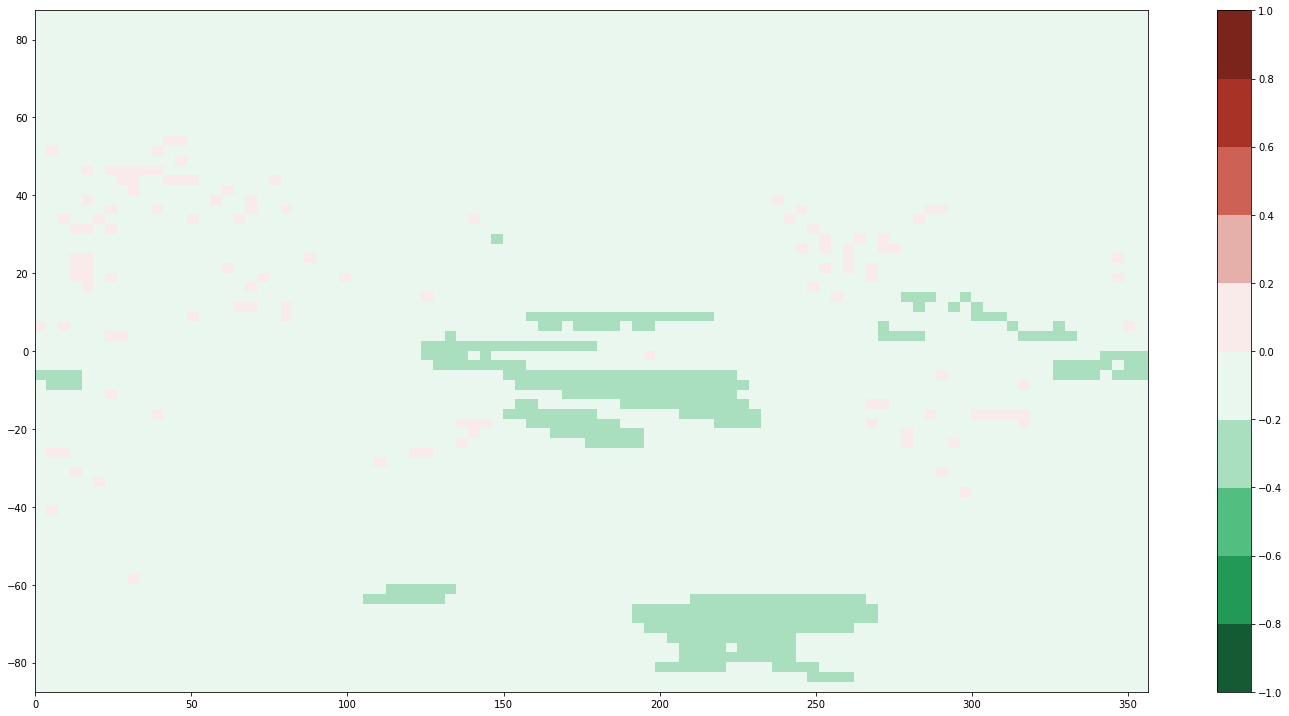

In [17]:
para = df_rmse_geolist/std -1

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#145a32", "#229954", "#52be80", "#a9dfbf",  "#e9f7ef", "#f9ebea", "#e6b0aa", "#cd6155", "#a93226", "#7b241c"]
bounds = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1] 
cmap= matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(
    long, lat, para, 
    cmap=cmap,
    vmin=-1, vmax=1, 
    norm=norm
)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    ticks=bounds, 
    spacing='proportional'
)

In [18]:
file = open("rmse_norm_rfr_pca.txt", "w")
dump = "\n".join((df_rmse_geolist/std -1).values.reshape(71*96).astype(str).tolist())
file.write(dump)

144237

## RMSE over number of PC

In [7]:
iss = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 130, 160, 200, 250, 300, 400, 500, 600, 700, 800, 900]

In [ ]:
rmse_list = []

for n_pc in iss:
    pred_pc_n_pc, pred_norm_n_pc, pred_n_pc, Y_test_n_pc, do18_test_scaler_n_pc, do18_test_n_pc = rfr_pca(
        temp, precip, do18, n_temp=20, n_precip=20, n_y=n_pc
    )
    for j in range(10):
        pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = rfr_pca(
            temp, precip, do18, n_temp=20, n_precip=20, n_y=n_pc
        )
        pred_n_pc = pred_n_pc.append(pred)
        do18_test_n_pc = do18_test_n_pc.append(do18_test)
        
    pred_n_pc = pred_n_pc.reset_index(drop=True)
    do18_test_n_pc = do18_test_n_pc.reset_index(drop=True)
    
    rmse_geolist = []
    for pixel in do18_test_n_pc.columns.values:
        rmse_pixel = mean_squared_error(pred_n_pc[pixel].values, do18_test_n_pc[pixel].values, squared=False)
        rmse_geolist.append(rmse_pixel)
    
    df_rmse_geolist_n_pc = pd.DataFrame(np.asarray(rmse_geolist).reshape(71,96))
    rmse_list.append(df_rmse_geolist_n_pc.mean().mean())
    print(df_rmse_geolist_n_pc.mean().mean())

/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

0.9412403998808889
0.9281720206151055
0.9147104641383477
0.9013077396670427
0.8927917936477504
0.8908089144347585
0.8931581902576258
0.8891383404829175
0.8914472671312144
0.8914749795959133
0.8953792047405867
0.9011727085757997
0.8880139455119083
0.8910620795004918
0.8992373628806432
0.8913833476094886
0.8919346197356551
0.8934152943293528
0.8987083830114196
0.8956840407684926
0.8953765368875963
0.8976112220581273


In [9]:
rmse_list = []
rmse_pc = []
std_pc = []

for n_pc in iss:
    print("n_pc: {}".format(n_pc))
    pred_pc_n_pc, pred_norm_n_pc, pred_n_pc, Y_test_n_pc, do18_test_scaler_n_pc, do18_test_n_pc = rfr_pca(
        temp, precip, do18, n_temp=20, n_precip=20, n_y=n_pc
    )
    
    for j in range(15):
        pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = rfr_pca(
            temp, precip, do18, n_temp=20, n_precip=20, n_y=n_pc
        )
        pred_n_pc = pred_n_pc.append(pred)
        do18_test_n_pc = do18_test_n_pc.append(do18_test)
        
        pred_pc_n_pc = pred_pc_n_pc.append(pred_pc)
        Y_test_n_pc = Y_test_n_pc.append(Y_test)
        
    pred_n_pc = pred_n_pc.reset_index(drop=True)
    do18_test_n_pc = do18_test_n_pc.reset_index(drop=True)
    pred_pc_n_pc = pred_pc_n_pc.reset_index(drop=True)
    Y_test_n_pc = Y_test_n_pc.reset_index(drop=True)
    
    std_pc.append(Y_test_n_pc.std().values.mean())
    rmse_temp = []
    for pc in pred_pc_n_pc.columns.values:
        rmse = mean_squared_error(pred_pc_n_pc[pc].values, Y_test_n_pc[pc].values, squared=False)
        rmse_temp.append(rmse)

    rmse_pc.append(np.mean(rmse_temp))
    print(np.mean(rmse_temp)) ##################################
    print(Y_test_n_pc.std().values.mean()) ##############################
    
    rmse_geolist = []
    for pixel in do18_test_n_pc.columns.values:
        rmse_pixel = mean_squared_error(pred_n_pc[pixel].values, do18_test_n_pc[pixel].values, squared=False)
        rmse_geolist.append(rmse_pixel)
    
    df_rmse_geolist_n_pc = pd.DataFrame(np.asarray(rmse_geolist).reshape(71,96))
    rmse_list.append(df_rmse_geolist_n_pc.mean().mean())
    print(df_rmse_geolist_n_pc.mean().mean()) #############################
    print("")

n_pc: 1


/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nadine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

7.098675274939012
18.120880599243037
0.9392690074765997

n_pc: 2
9.043098424284711
17.122634995752634
0.9294015162372341

n_pc: 3
9.579795684238206
16.670284165371104
0.9171622092385802

n_pc: 5
9.362543336906885
15.489694588000237
0.9043504933508548

n_pc: 7
9.166520856182645
14.046644554419762
0.8945014506424248

n_pc: 10
9.065005647091889
12.68673211061857
0.8945076466548961

n_pc: 15
8.729656789726826
11.210080377796
0.8931176942904197

n_pc: 20
8.364372473724881
10.276292936481614
0.8920203575169209

n_pc: 25
8.068824652038934
9.610897264252037
0.8948882728825654

n_pc: 30
7.6847160747332275
8.964484478950252
0.8930056439761663

n_pc: 40
7.160801170101601
8.112918242241449
0.894125732897798

n_pc: 50
6.6778359372181955
7.441501766471756
0.8937342763174247

n_pc: 60
6.285451673789428
6.914684216235772
0.8923534017700167

n_pc: 80
5.7293558571906775
6.189091604624368
0.8944415199074921

n_pc: 100
5.306949014031023
5.66518924220476
0.8962580232047742

n_pc: 130
4.857521275322864
5.12

In [13]:
error_pc = []
for n_pc in iss:
    scaler_do18 = StandardScaler().fit(do18)
    do18_scaler = scaler_do18.transform(do18)
    pca_do18 = PCA(n_components=n_pc).fit(do18_scaler)
    do18_pc = pca_do18.transform(do18_scaler)
    
    do18_inv = scaler_do18.inverse_transform(pca_do18.inverse_transform(do18_pc))
    error_pc.append(mean_squared_error(do18_inv, do18, squared=False))


In [13]:
rmse_pc = np.asarray(rmse_pc)
std_pc = np.asarray(std_pc)
rmse_list = np.asarray(rmse_list)
rmse_std_list = rmse_list/(std.mean().mean())

In [20]:
for i in rmse_list:
    print(i)

0.9392690074765997
0.9294015162372341
0.9171622092385802
0.9043504933508548
0.8945014506424248
0.8945076466548961
0.8931176942904197
0.8920203575169209
0.8948882728825654
0.8930056439761663
0.894125732897798
0.8937342763174247
0.8923534017700167
0.8944415199074921
0.8962580232047742
0.9010686356046139
0.8927913174331125
0.8983853063433574
0.900242349353675
0.894298113075433
0.8973356931469237
0.8989550816084314
0.9012490957093563
0.9004275279280683
0.9026783580096347
0.9049725161864446


In [9]:
with open("rfr_rmse_list.txt") as f:
    rmse_list = f.readlines()
rmse_list = np.asarray(rmse_list).astype(float)
rmse_list

array([0.93926901, 0.92940152, 0.91716221, 0.90435049, 0.89450145,
       0.89450765, 0.89311769, 0.89202036, 0.89488827, 0.89300564,
       0.89412573, 0.89373428, 0.8923534 , 0.89444152, 0.89625802,
       0.90106864, 0.89279132, 0.89838531, 0.90024235, 0.89429811,
       0.89733569, 0.89895508, 0.9012491 , 0.90042753, 0.90267836,
       0.90497252])

In [10]:
with open("rfr_rmse_std_list.txt") as f:
    rmse_std_list = f.readlines()
rmse_std_list = np.asarray(rmse_std_list).astype(float)
rmse_std_list

array([0.9797733 , 0.96948029, 0.95671318, 0.94334898, 0.93307522,
       0.93308168, 0.93163179, 0.93048713, 0.93347872, 0.93151491,
       0.9326833 , 0.93227496, 0.93083454, 0.9330127 , 0.93490754,
       0.9399256 , 0.93129134, 0.93712656, 0.93906368, 0.93286311,
       0.93603168, 0.9377209 , 0.94011384, 0.93925685, 0.94160474,
       0.94399783])

In [11]:
with open("rfr_std_pc.txt") as f:
    std_pc = f.readlines()
std_pc = np.asarray(std_pc).astype(float)
std_pc

array([18.1208806 , 17.122635  , 16.67028417, 15.48969459, 14.04664455,
       12.68673211, 11.21008038, 10.27629294,  9.61089726,  8.96448448,
        8.11291824,  7.44150177,  6.91468422,  6.1890916 ,  5.66518924,
        5.12564158,  4.65665452,  4.28175204,  3.91511363,  3.59833715,
        3.1972539 ,  2.9010568 ,  2.66983453,  2.48187312,  2.32258846,
        2.1811024 ])

In [12]:
with open("rfr_rmse_pc.txt") as f:
    rmse_pc = f.readlines()
rmse_pc = np.asarray(rmse_pc).astype(float)
rmse_pc

array([7.09867527, 9.04309842, 9.57979568, 9.36254334, 9.16652086,
       9.06500565, 8.72965679, 8.36437247, 8.06882465, 7.68471607,
       7.16080117, 6.67783594, 6.28545167, 5.72935586, 5.30694901,
       4.85752128, 4.43972039, 4.12155783, 3.79191555, 3.4983339 ,
       3.13047955, 2.85098148, 2.63314788, 2.45192305, 2.29947817,
       2.16313507])

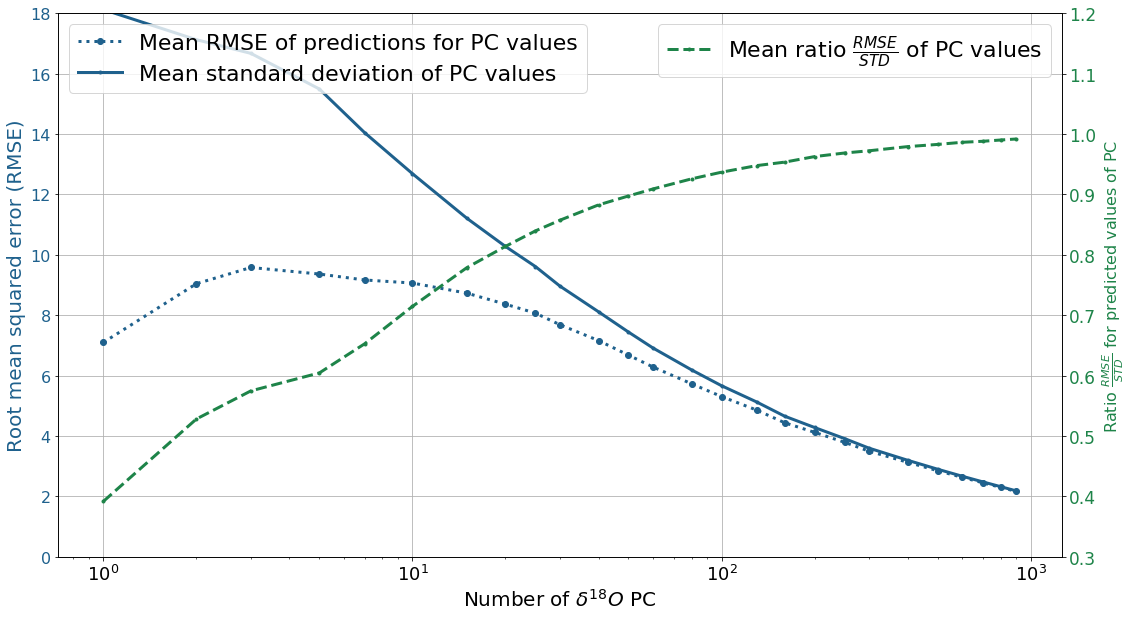

In [15]:
fig, ax1 = plt.subplots(figsize=(18,10))
ax2 = ax1.twinx()
ax1.set_xlabel(r"Number of $\delta^{18}O$ PC", fontsize=20)
ax1.set_xscale("log")
ax1.tick_params(axis="x", labelsize=18)

ax1.plot(iss, rmse_pc, "o:", linewidth=3, color="#1f618d", label="Mean RMSE of predictions for PC values")
ax1.plot(iss, std_pc, ".-", linewidth=3, color="#1f618d", label="Mean standard deviation of PC values")
ax1.tick_params(axis='y', labelsize=16, labelcolor="#1f618d")
ax1.set_ylim(0,18)
ax1.set_ylabel("Root mean squared error (RMSE)", fontsize=20, color="#1f618d")
ax1.grid()


ax2.set_ylabel(r"Ratio $\frac{RMSE}{STD}$ for predicted values of PC", fontsize=16, color="#1e8449")
ax2.plot(iss, rmse_pc/std_pc, ".--" , linewidth=3, color="#1e8449", label=r"Mean ratio $ \frac{RMSE}{STD}$ of PC values")
ax2.set_ylim(0.3,1.2)
ax2.tick_params(axis='y', labelsize=17, labelcolor="#1e8449")
ax1.legend(fontsize=22, loc="upper left")
ax2.legend(fontsize=22, loc="upper right")

plt.savefig("figures/rfr_pca_npc_pc.png", bbox_inches="tight")
plt.show()

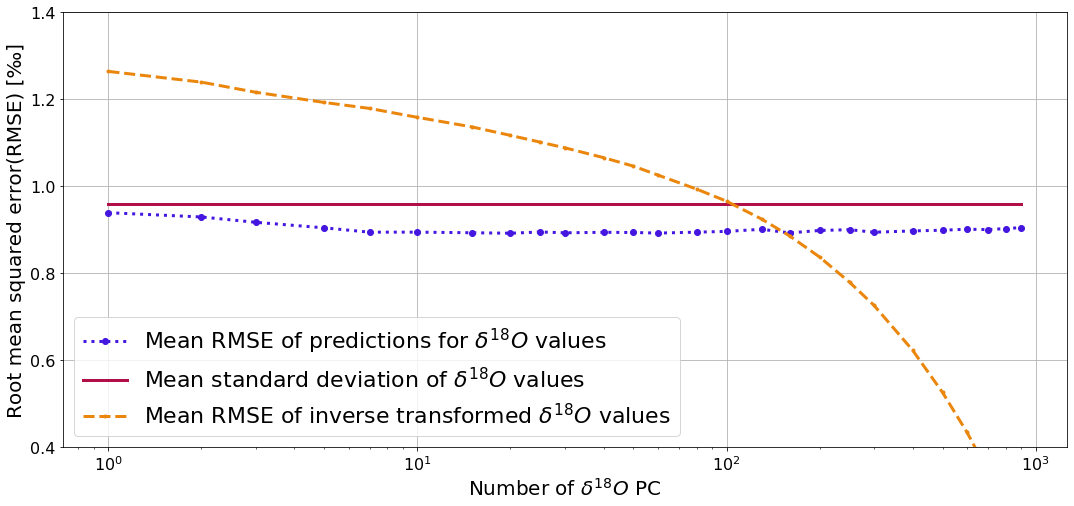

In [17]:
plt.figure(figsize=(18,8))

plt.xlabel("Number of $\delta^{18}O$ PC", fontsize=20)
plt.xscale("log")

plt.plot(iss, rmse_list, "o:", color="#4416e0", linewidth=3, label="Mean RMSE of predictions for $\delta^{18}O$ values")
plt.plot(iss, [std.mean().mean()]*len(iss), "-", color="#b01047", linewidth=3, label=r"Mean standard deviation of $\delta^{18}O$ values")
plt.plot(iss, error_pc, ".--", color="#eb860c", linewidth=3, label="Mean RMSE of inverse transformed $\delta^{18}O$ values")
plt.ylim(0.4,1.4)
plt.ylabel("Root mean squared error(RMSE) [‰]", fontsize=20)
plt.grid()


plt.legend(fontsize=22, loc="lower left")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.savefig("figures/rfr_pca_npc.png", bbox_inches="tight")
plt.show()

## Feature importances


In [79]:
def rfr_pca_feature_importances(temp, precip, do18, n_temp=20, n_precip=20, n_y=20, train_proportion=0.9, random=True):
    
    if random:
        random_idx = np.random.permutation(do18.index.values)
    
        temp = temp.reindex(random_idx)
        precip = precip.reindex(random_idx)
        do18 = do18.reindex(random_idx)
    
    #devide training and test data
    do18_train = do18[:int(np.floor(train_proportion*len(do18)))].reset_index(drop=True)
    do18_test = do18[int(np.floor(train_proportion*len(do18))):].reset_index(drop=True)

    temp_train = temp[:int(np.floor(train_proportion*len(temp)))].reset_index(drop=True)
    temp_test = temp[int(np.floor(train_proportion*len(temp))):].reset_index(drop=True)

    precip_train = precip[:int(np.floor(train_proportion*len(precip)))].reset_index(drop=True)
    precip_test = precip[int(np.floor(train_proportion*len(precip))):].reset_index(drop=True)
    
    #define scalers
    scaler_temp = StandardScaler().fit(temp)
    scaler_precip = StandardScaler().fit(precip)
    scaler_do18 = StandardScaler().fit(do18)
    
    #scale data
    do18_train_scaler = scaler_do18.transform(do18_train)
    do18_test_scaler = scaler_do18.transform(do18_test)

    temp_train_scaler = scaler_temp.transform(temp_train)
    temp_test_scaler = scaler_temp.transform(temp_test)

    precip_train_scaler = scaler_precip.transform(precip_train)
    precip_test_scaler = scaler_precip.transform(precip_test)
    
    #define pcas and fit data
    pca_temp = PCA(n_components=n_temp).fit(np.append(temp_train_scaler, temp_test_scaler, axis=0))
    pca_precip = PCA(n_components=n_precip).fit(np.append(precip_train_scaler, precip_test_scaler, axis=0))
    pca_do18 = PCA(n_components=n_y).fit(np.append(do18_train_scaler, do18_test_scaler, axis=0))
    
    #transform data
    do18_train_pc = pca_do18.transform(do18_train_scaler)
    do18_test_pc = pca_do18.transform(do18_test_scaler)

    temp_train_pc = pca_temp.transform(temp_train_scaler)
    temp_test_pc = pca_temp.transform(temp_test_scaler)

    precip_train_pc = pca_precip.transform(precip_train_scaler)
    precip_test_pc = pca_precip.transform(precip_test_scaler)
    
    
    X_train = np.append(temp_train_pc, precip_train_pc, axis=1)
    X_test = np.append(temp_test_pc, precip_test_pc, axis=1)

    Y_train = do18_train_pc
    Y_test = pd.DataFrame(do18_test_pc)
    
    Y = pd.DataFrame(np.append(Y_train, Y_test, axis=0))
    
    #train model
    regressor = RandomForestRegressor().fit(X_train, Y_train)
    
    #predict test data
    pred_pc = pd.DataFrame(regressor.predict(X_test))
    pred_norm = pd.DataFrame(pca_do18.inverse_transform(pred_pc))
    pred = pd.DataFrame(scaler_do18.inverse_transform(pred_norm))
    
    importances = list(regressor.feature_importances_)
    feature_list = []
    for i in range(n_temp):
        feature_list.append("Temp. component {}".format(i))
    for i in range(n_precip):
        feature_list.append("Precip. component {}".format(i))
    
    
    plt.figure(figsize=(20,10))
    plt.bar(feature_list, importances)
    plt.title("Feature importances n_y={}".format(n_y))
    plt.ylabel("Importance")
    plt.grid()
    x_values = list(range(len(importances)))
    plt.xticks(x_values, feature_list, rotation='vertical')
    
    
    #return pca and final data
    return feature_list, importances

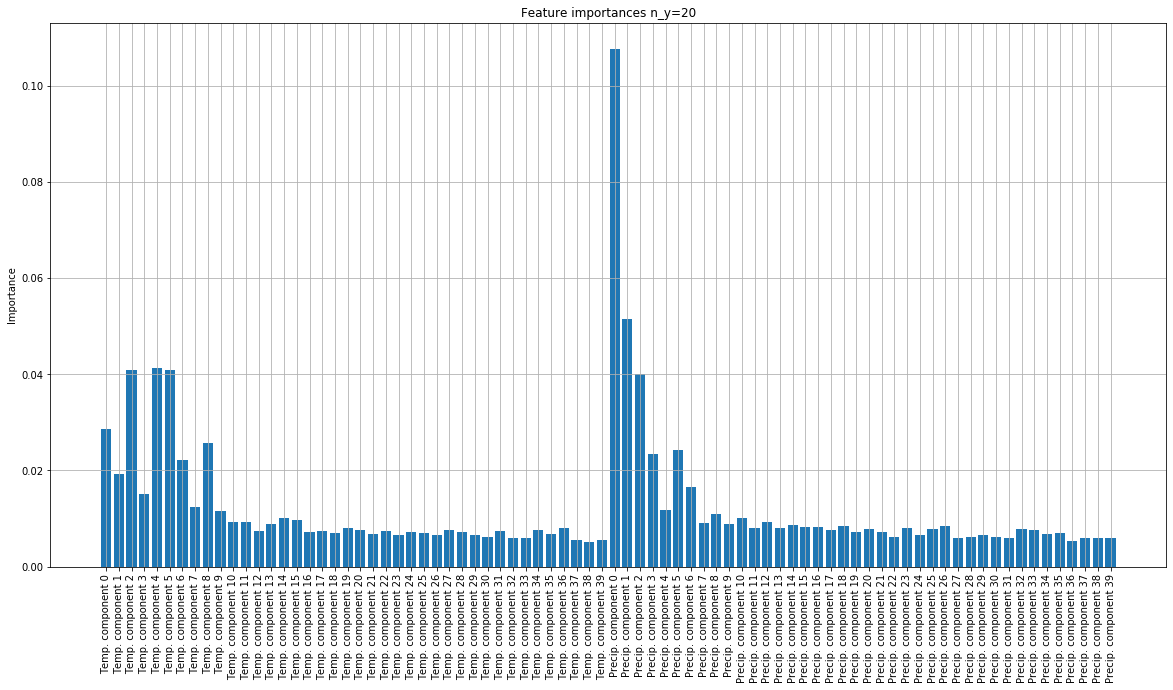

In [80]:
feature_list, importances = rfr_pca_feature_importances(temp, precip, do18, n_temp=40, n_precip=40, n_y=20)

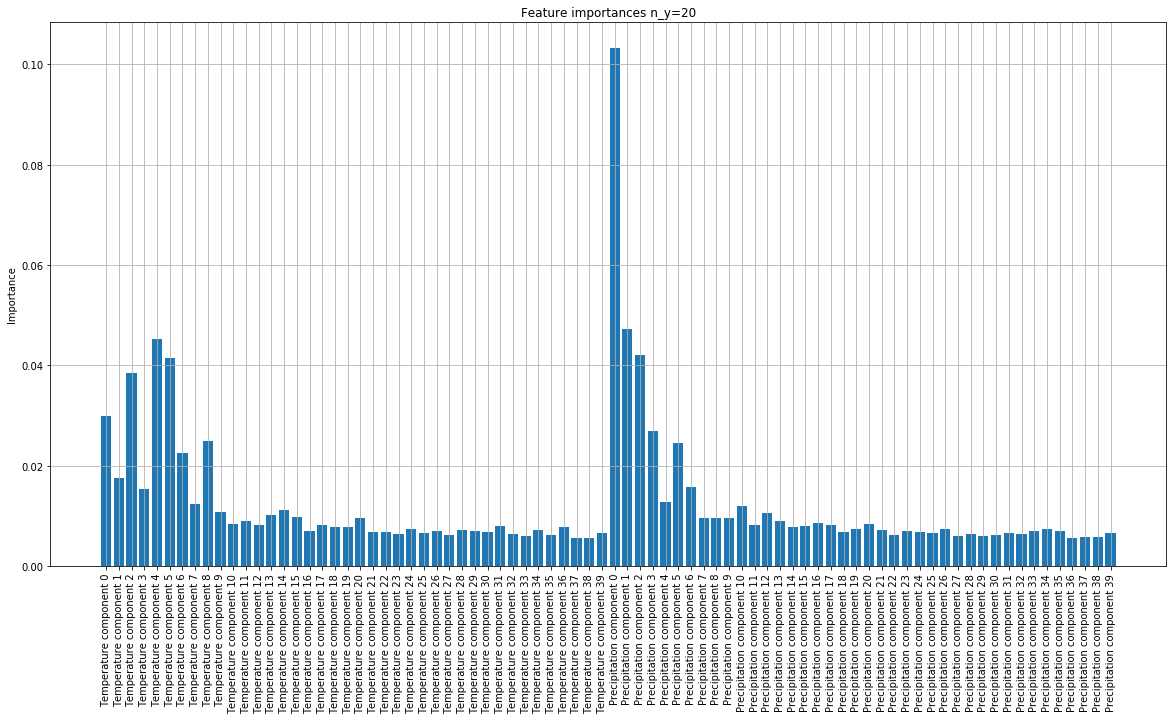

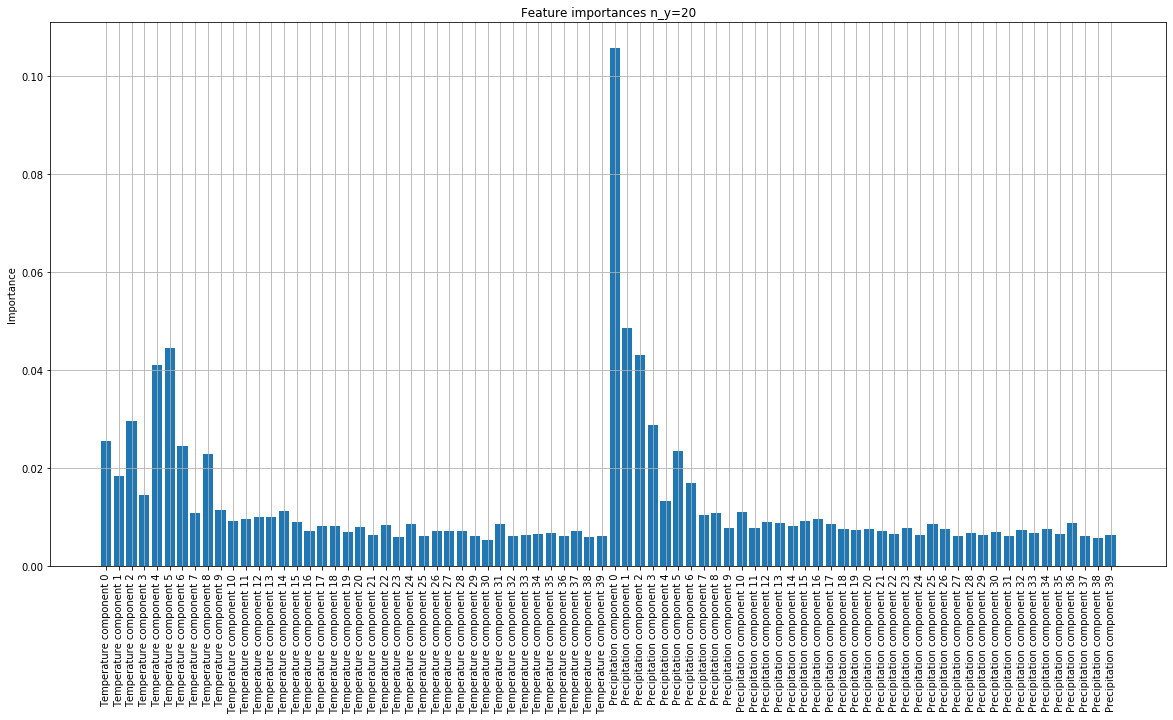

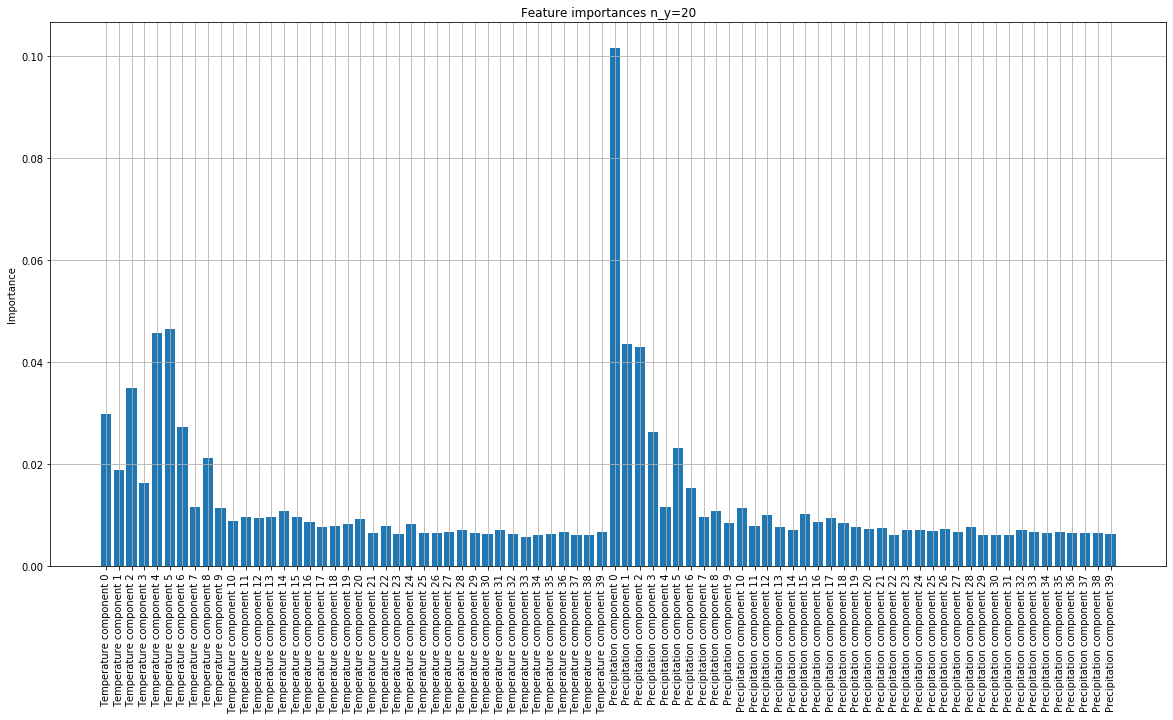

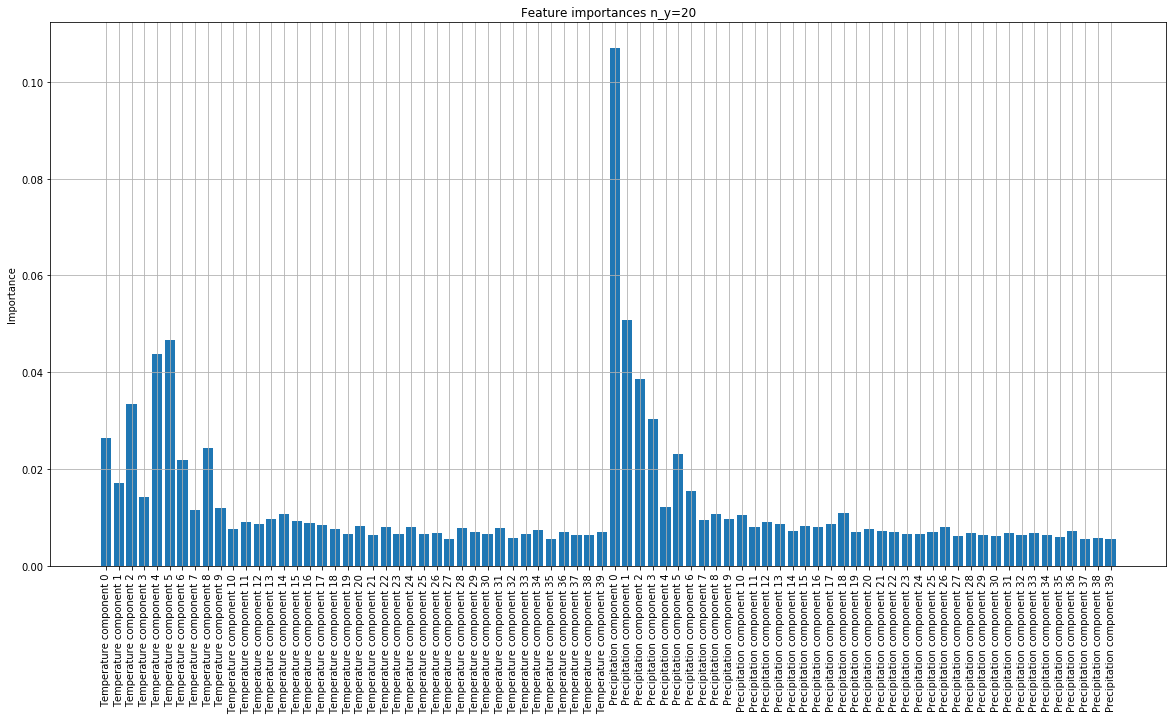

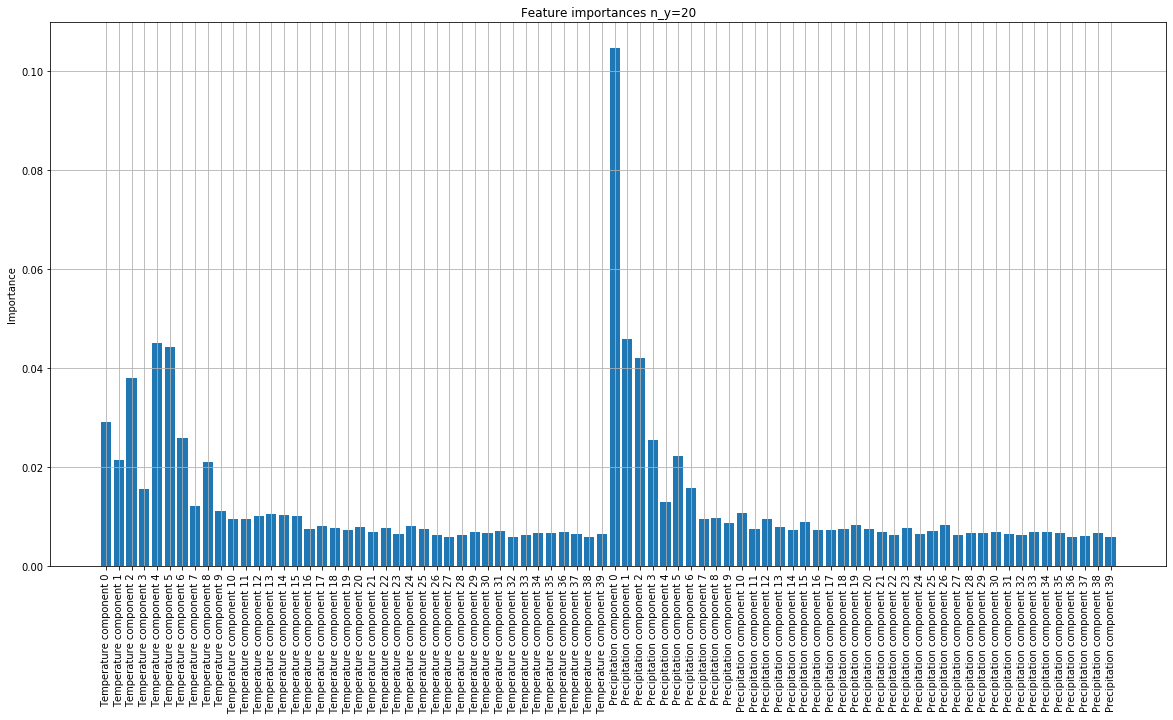

In [73]:
feature_list = None
importances_list = []
for i in range(5):
    feature_list, importances = rfr_pca_feature_importances(temp, precip, do18, n_temp=40, n_precip=40, n_y=20)
    importances_list.append(importances)

In [101]:
df_importances = pd.DataFrame(np.asarray(importances_list))
importances = df_importances.mean().values
importances_accumulated = np.append(np.cumsum(importances[:40]), np.cumsum(importances[40:]))

In [118]:
df_plot = pd.DataFrame(index=feature_list, data=importances)
df_plot[1]=(importances_accumulated)
df_plot

,0,1
Temp. component 0,0.028115,0.028115
Temp. component 1,0.018605,0.046720
Temp. component 2,0.034911,0.081631
Temp. component 3,0.015132,0.096763
Temp. component 4,0.044164,0.140927
...,...,...
Precip. component 35,0.006578,0.495892
Precip. component 36,0.006746,0.502638
Precip. component 37,0.005967,0.508605
Precip. component 38,0.006014,0.514619


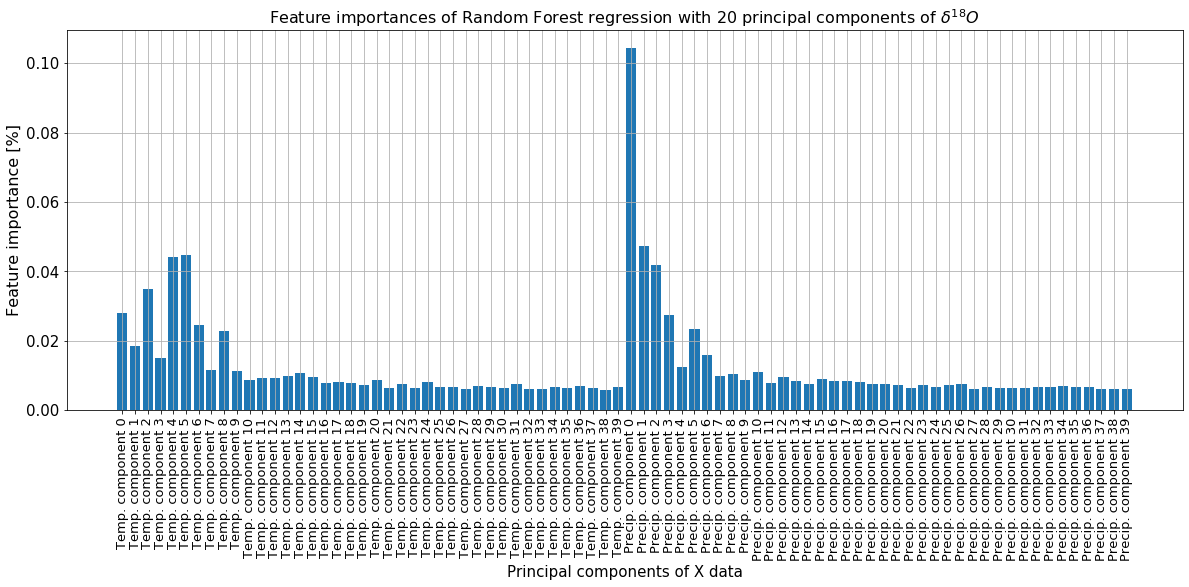

In [142]:
plt.figure(figsize=(20,7))
plt.bar(feature_list, height=importances)
plt.title(r"Feature importances of Random Forest regression with 20 principal components of $\delta^{18}O$", fontsize=16)
plt.ylabel("Feature importance [%]", fontsize=16)
plt.grid()
x_values = list(range(len(df_importances.mean().values)))
plt.xticks(x_values, feature_list, rotation='vertical', fontsize=13)
plt.yticks(fontsize=15)
plt.xlabel("Principal components of X data", fontsize=15)
plt.savefig("figures/rfr_pca_imp.png")
plt.show()

In [34]:
with open("rfr_rmse_list.txt") as f:
    rfr_rmse_list = f.readlines()
rfr_rmse_list = np.asarray(rfr_rmse_list).astype(float)
rfr_rmse_list

array([0.93926901, 0.92940152, 0.91716221, 0.90435049, 0.89450145,
       0.89450765, 0.89311769, 0.89202036, 0.89488827, 0.89300564,
       0.89412573, 0.89373428, 0.8923534 , 0.89444152, 0.89625802,
       0.90106864, 0.89279132, 0.89838531, 0.90024235, 0.89429811,
       0.89733569, 0.89895508, 0.9012491 , 0.90042753, 0.90267836,
       0.90497252])

In [35]:
with open("mlr_rmse_list.txt") as f:
    mlr_rmse_list = f.readlines()
mlr_rmse_list = np.asarray(mlr_rmse_list).astype(float)
mlr_rmse_list

array([0.94198881, 0.93129207, 0.90579269, 0.89232422, 0.88204766,
       0.87125236, 0.89162474, 0.88725494, 0.83830702, 0.8480503 ,
       0.87433544, 0.84695558, 0.85104769, 0.84402946, 0.84651036,
       0.82745533, 0.91996522, 0.874814  , 0.8852012 , 0.89258526,
       0.89691878, 0.86848433, 0.90482657, 0.82366177, 0.82429976,
       0.92300349, 0.81572833, 0.91676663, 0.87726104, 0.96702372,
       0.97180763, 0.97092452, 0.8943747 , 0.92560964, 0.88573432,
       0.89841024, 0.95067785, 0.94931674])

In [ ]:
fig, ax1 = plt.subplots(figsize=(18,12))
#ax2 = ax1.twinx()

ax1.set_xlabel("Number of $\delta^{18}O$ principal components", fontsize=17)
ax1.set_xscale("log")

ax1.plot(iss, rmse_list, ".:", color="#1f618d", label="Mean RMSE of predictions for $\delta^{18}O$ values in all pixels")
ax1.plot(iss, [std.mean().mean()]*len(iss), "-", label=r"Mean standard deviation of $\delta^{18}O$ values in all pixels", color="#1f618d")
ax1.plot(iss, error_pc, ".--", color="#1f618d", label="Mean RMSE of inverse transformed $\delta^{18}O$ values in all pixels")
ax1.set_ylim(0.2,1.4)
ax1.tick_params(axis='y', labelcolor="#1f618d")
ax1.set_ylabel("Root mean squared error(RMSE)", fontsize=16, color="#1f618d")
ax1.grid()

#ax2.set_ylabel(r"Ratio $ \frac{RMSE}{STD}$ of $\delta^{18}O$ predictions in all pixels", fontsize=16, color="#1e8449")
#ax2.plot(iss, rmse_std_list, ".:" ,color="#1e8449", label=r"Mean ratio $ \frac{RMSE}{STD}$ of $\delta^{18}O$ predictions")
#ax2.set_ylim(0.,1.2)
ax2.tick_params(axis='y', labelcolor="#1e8449")

ax1.legend(fontsize=16, loc="lower left")
#ax2.legend(fontsize=16, loc="upper right")

plt.show()

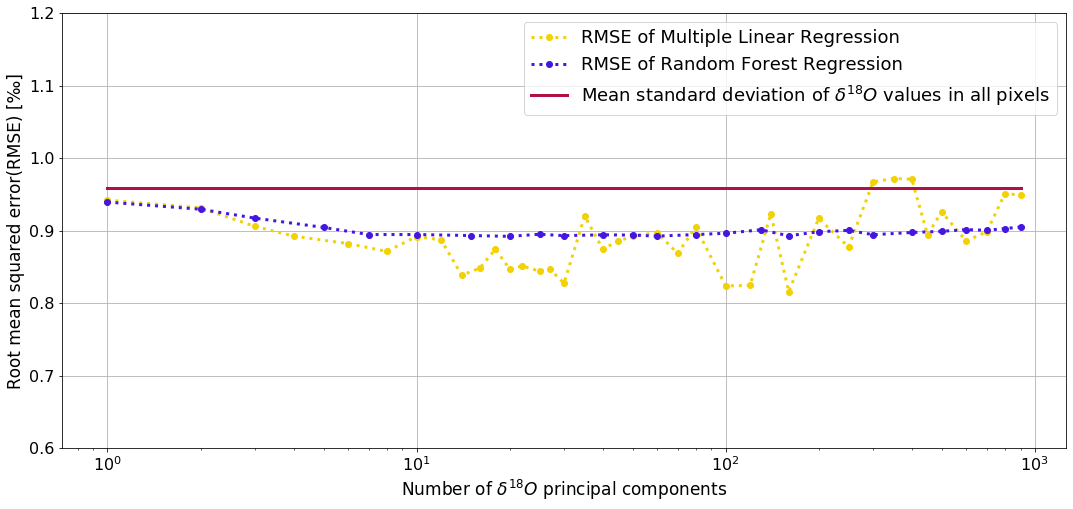

In [126]:
plt.figure(figsize=(18,8))
iss_mlr = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 27, 30, 35, 40, 45, 50, 60, 70, 80, 100, 120, 140, 160, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900]
plt.plot(iss_mlr, mlr_rmse_list, "o:", linewidth=3, color="#f3d204", label="RMSE of Multiple Linear Regression")
plt.plot(iss, rfr_rmse_list, "o:", linewidth=3, color="#4416e0", label="RMSE of Random Forest Regression")
plt.xscale("log")
plt.ylim(0.6,1.2)
plt.plot(iss, [std.mean().mean()]*len(iss), "-", linewidth=3, color="#b01047", label=r"Mean standard deviation of $\delta^{18}O$ values in all pixels")
plt.legend(fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel("Number of $\delta^{18}O$ principal components", fontsize=17)
plt.ylabel("Root mean squared error(RMSE) [‰]", fontsize=17)
plt.grid()

plt.savefig("figures/mlr_rfr_error.png")
plt.show()